In [2]:
import os
import glob
import numpy as np
import pandas as pd

from scipy.spatial.distance import pdist, squareform
from scipy.stats import rankdata, ttest_rel, ttest_1samp, pearsonr, spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib


from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import cross_val_predict, StratifiedKFold, cross_val_score, permutation_test_score
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, pairwise_distances
from imblearn.over_sampling import SMOTE 

%matplotlib inline

In [3]:
 
def make_TR(input_list):
    return [round(x/2) for x in input_list]
    
def remove_out_of_bounds(input_list, lower_bound=15, upper_bound=1493-15):
    return [item for item in input_list if lower_bound <= item <= upper_bound]

def clean_time_point(input_list):
    
    output_list = []
    
    # remove out of bounds
    bounds = [15, 1493-15]
    output_list = [item for item in input_list if bounds[0] <= item <= bounds[1]]

    # remove each run end
    for TR_i in [ 250, 549, 742, 946, 1232, 1493]:
        output_list = [item for item in output_list if ( TR_i+15 <= item) or( item <= TR_i-15)]

    return output_list
    

In [6]:

base_dir = '/Users/li/Desktop/debate/braindata'

sub_list = [f'sub-{x:0>3d}' for x in range(13,51)]
sub_list.remove('sub-021')

subs_roi_data = []
for sub in sub_list:
    csv_file = f'/Volumes/Li/task-debate/braindata/denoised 5/parcel data/Schaefer 200 combine 6 runs/{sub}_combined_time-series_Schaefer2018_200Parcels_7Networks.csv'
    sub_data = pd.read_csv(csv_file)
    subs_roi_data.append(sub_data.values)

all_brain_data = np.array(subs_roi_data)
all_brain_data.shape

(37, 1493, 200)

In [8]:
roi_name = '7Networks_LH_Default_PFC_8'
sub_list = list(range(13, 51))
run_list = [1,2,3,4,5,6]
sub_list.remove(21)

seed_roi_index = 89

results = []
for sub_idx, sub  in enumerate(sub_list):
    
    # change time point（秒）
    sub_time_file = f'/Users/li/Desktop/debate/behavedata/during_scan/combined_6runs_filter_diff/subject_{sub}_rate_diff.csv'
    sub_time = pd.read_csv(sub_time_file)

    change_time = list(sub_time['time'][1:])
    change_time = make_TR(change_time)
    
    #change_time = remove_out_of_bounds(change_time)
    change_time = clean_time_point(change_time)
    
    pre_rate = list(sub_time['rate'][:-1])
    change = list(sub_time['rate_diff'][1:])

    # sub's brain data
    sub_data = all_brain_data[sub_idx,:,:]

    for i, point in enumerate(change_time):
        
        idx = point
        start_idx = idx - 15
        end_idx = idx + 15

        seed_data = sub_data[start_idx:end_idx, seed_roi_index]
        other_data = np.delete(sub_data, seed_roi_index, axis=1)
        other_data = other_data[start_idx:end_idx, :]

        correlations = []
        for roi in range(other_data.shape[1]):  # 遍历所有脑区
                corr, _ = pearsonr(seed_data, other_data[:, roi])
                correlations.append(corr)

        
        row_data = {'subject': sub, 'change_time': change_time[i], 'pre_rate': pre_rate[i], 'change': change[i],'type':None}

        for j, r in enumerate(np.arctanh(correlations)):
            row_data[f'edge_{j+1}'] = r
        
        results.append(row_data)
        
df = pd.DataFrame(results)
df


,subject,change_time,pre_rate,change,type,edge_1,edge_2,edge_3,edge_4,edge_5,...,edge_190,edge_191,edge_192,edge_193,edge_194,edge_195,edge_196,edge_197,edge_198,edge_199
0,13,205,12,1.0,None,-0.119691,-0.123203,-0.327155,0.143386,-0.067198,...,0.043829,0.637291,0.803069,-0.064725,-0.202667,0.161121,0.207639,0.186001,0.068580,-0.031679
1,13,330,13,1.0,None,0.247874,-0.362771,-0.099006,0.143341,-0.534102,...,-0.084254,0.390954,0.922204,0.339173,0.056768,-0.068756,0.006551,0.243087,-0.129177,0.174374
2,13,381,14,-1.0,None,-0.380871,-0.144694,-0.339756,0.226879,-0.207797,...,0.370154,0.629705,0.511291,-0.097267,-0.252118,0.194074,0.221843,-0.394103,-0.201423,-0.336033
3,13,590,13,1.0,None,-0.170526,-0.496900,-0.434197,0.063185,-0.116419,...,0.034992,-0.075437,0.735921,-0.070407,0.071275,0.609825,0.486051,0.299641,0.453165,0.563621
4,13,603,14,-1.0,None,0.050339,-0.238501,-0.280272,0.039021,-0.079649,...,-0.145123,0.079992,1.093376,0.082158,0.310095,0.575366,0.614675,0.220158,0.092013,0.114236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,50,704,10,-2.0,None,-0.383147,-0.293752,-0.309080,0.045308,-0.087947,...,-0.225068,0.669660,1.002349,0.450050,-0.043097,0.784336,0.648287,-0.202639,0.103823,0.424028
598,50,724,8,-1.0,None,-0.259290,-0.164560,-0.350087,0.165290,-0.080615,...,0.002548,0.609125,0.694980,0.769336,0.702705,0.579528,0.440104,-0.199722,0.480657,0.114345
599,50,905,7,-1.0,None,0.110526,-0.280094,-0.337725,0.033530,-0.469218,...,-0.273373,0.292747,0.751430,0.316643,0.581145,0.379421,0.067291,0.046799,0.260067,0.305108
600,50,1084,6,-1.0,None,0.229586,-0.125385,-0.473566,0.451475,-0.280991,...,-0.183376,0.236774,0.236530,0.224856,0.170866,0.448287,0.258721,0.247442,0.377181,0.337105


In [10]:

df_expanded = df.copy()

def set_type(row):
    if row['pre_rate'] > 7 and row['change'] > 0:
        return 1
    elif row['pre_rate'] > 7 and row['change'] < 0:
        return 2
    elif row['pre_rate'] < 7 and row['change'] < 0:
        return 3
    elif row['pre_rate'] < 7 and row['change'] > 0:
        return 4
    else:
        return None  
        
df_expanded['type'] = df_expanded.apply(set_type, axis=1)
df_expanded = df_expanded.dropna(subset=['type'])

print(df_expanded.shape)


(543, 204)


In [17]:

from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

X = df_expanded.drop(columns=['subject', 'change_time', 'pre_rate', 'change','type'])  # 特征是pattern
y = df_expanded['type']  # 目标是type

svm_model = SVC(class_weight='balanced')
score, permutation_scores, pvalue = permutation_test_score(
    svm_model, X, y, cv=kfold, n_permutations=1000, n_jobs=-1, scoring="accuracy", random_state=42)

print(f"置换检验得分: {score:.2f}")
print(f"置换检验的p值: {pvalue:.4f}")

print()
print("混淆矩阵:")
y_pred = cross_val_predict(svm_model, X, y, cv=loo)
conf_matrix = confusion_matrix(y, y_pred)
print(conf_matrix)

accuracy = accuracy_score(y, y_pred)
print(f"loo 正确率: {accuracy:.2f}")



置换检验得分: 0.44
置换检验的p值: 0.0010

混淆矩阵:
[[106  52  16  28]
 [ 65  87  19  17]
 [ 17  12  24  17]
 [ 21   7  22  33]]
loo 正确率: 0.46


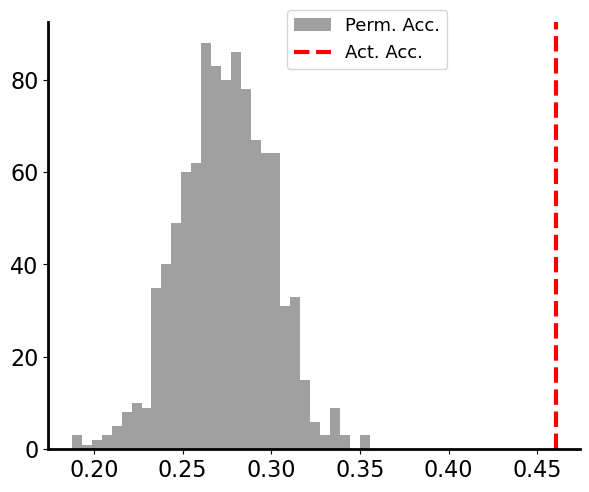

In [29]:

plt.figure(figsize=(6, 5))
# 可视化置换检验结果
plt.hist(permutation_scores, bins=30, alpha=0.75, color='grey', label='Perm. Acc.')
plt.axvline(accuracy, color='red', linestyle='--', linewidth=3, label='Act. Acc.')
plt.xticks(fontsize=16)  # 设置 x 轴刻度字体大小
plt.yticks(fontsize=16)  # 设置 y 轴刻度字体大小

# 去掉上面和左边的框线
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 设置 y 轴坐标从 0.05 开始
# plt.ylim(bottom=0.05)

# 加粗左边和下边的轴线
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

plt.legend(loc='upper center', bbox_to_anchor=(0.6, 1.05), fontsize=13)

# plt.legend(title="Network", bbox_to_anchor=(1.01, 1), borderaxespad=0, fontsize=12, title_fontsize=13)

plt.tight_layout()
# 保存图像
plt.savefig('/Users/li/Desktop/Figure/6d_whole_brain.png', dpi=300)
# plt.xlabel('Accuracy Score')
# plt.ylabel('Frequency')
# plt.title('Permutation Test Results')

plt.show()

(602, 204)
置换检验得分: 0.60
置换检验的p值: 0.0010
混淆矩阵:
[[163 124]
 [108 207]]
分类报告:
              precision    recall  f1-score   support

          -1       0.60      0.57      0.58       287
           1       0.63      0.66      0.64       315

    accuracy                           0.61       602
   macro avg       0.61      0.61      0.61       602
weighted avg       0.61      0.61      0.61       602

loo 正确率: 0.61


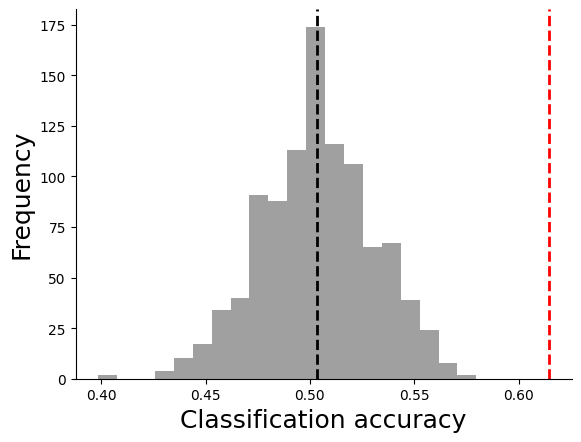

In [9]:

df_expanded = df.copy()

def set_type(row):
    if row['change'] > 0:
        return 1
    else:
        return -1

        
df_expanded['type'] = df_expanded.apply(set_type, axis=1)
df_expanded = df_expanded.dropna(subset=['type'])

print(df_expanded.shape)

X = df_expanded.drop(columns=['subject', 'change_time', 'pre_rate', 'change','type'])  # 特征是pattern
y = df_expanded['type']  # 目标是type


cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
svm_model = SVC(class_weight='balanced')

from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
score, permutation_scores, pvalue = permutation_test_score(
    svm_model, X, y, cv=cv, n_permutations=1000, n_jobs=-1, scoring="accuracy", random_state=42)

print(f"置换检验得分: {score:.2f}")
print(f"置换检验的p值: {pvalue:.4f}")
y_pred = cross_val_predict(svm_model, X, y, cv=loo)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y, y_pred)

# 输出混淆矩阵
print("混淆矩阵:")
print(conf_matrix)

# 输出详细的分类报告（精确率、召回率、F1-score）
print("分类报告:")
print(classification_report(y, y_pred))

accuracy = accuracy_score(y, y_pred)
print(f"loo 正确率: {accuracy:.2f}")


# 绘制直方图
plt.hist(permutation_scores, bins=20, alpha=0.75, color='grey', label='Permutation accuracy')

# 绘制实际准确率的红色虚线
plt.axvline(accuracy, color='red', linestyle='--', linewidth=2, label=f'Actual Accuracy ({score:.2f})')
# 绘制置换得分平均值的黑色虚线
plt.axvline(np.mean(permutation_scores), color='black', linestyle='--', linewidth=2, label=f'Mean Permutation Accuracy ({np.mean(permutation_scores):.2f})')

# 添加标签
plt.xlabel('Classification accuracy',fontsize=18)
plt.ylabel('Frequency',fontsize=18)

# 去除图表的边框
sns.despine()

# 显示图例
# plt.legend(loc='best')
# plt.xticks(fontsize=14)  # 调整 x 轴刻度字体大小
# plt.yticks(fontsize=14) 
# 显示图形
plt.show()

(543, 204)
置换检验得分: 0.54
置换检验的p值: 0.0799
混淆矩阵:
[[150 122]
 [122 149]]
分类报告:
              precision    recall  f1-score   support

         1.0       0.55      0.55      0.55       272
         2.0       0.55      0.55      0.55       271

    accuracy                           0.55       543
   macro avg       0.55      0.55      0.55       543
weighted avg       0.55      0.55      0.55       543

loo 正确率: 0.55


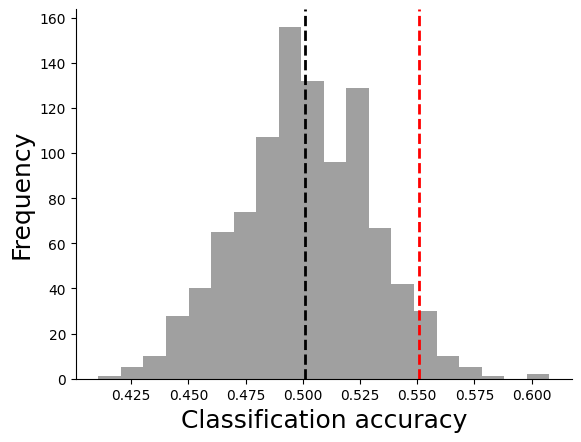

In [10]:

df_expanded = df.copy()

def set_type(row):
    if row['pre_rate'] > 7 and row['change'] > 0:
        return 1
    elif row['pre_rate'] > 7 and row['change'] < 0:
        return 2
    elif row['pre_rate'] < 7 and row['change'] < 0:
        return 1
    elif row['pre_rate'] < 7 and row['change'] > 0:
        return 2
    else:
        return None  


        
df_expanded['type'] = df_expanded.apply(set_type, axis=1)
df_expanded = df_expanded.dropna(subset=['type'])

print(df_expanded.shape)

X = df_expanded.drop(columns=['subject', 'change_time', 'pre_rate', 'change','type'])  # 特征是pattern
y = df_expanded['type']  # 目标是type


cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
svm_model = SVC(class_weight='balanced')

from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
score, permutation_scores, pvalue = permutation_test_score(
    svm_model, X, y, cv=cv, n_permutations=1000, n_jobs=-1, scoring="accuracy", random_state=42)

print(f"置换检验得分: {score:.2f}")
print(f"置换检验的p值: {pvalue:.4f}")
y_pred = cross_val_predict(svm_model, X, y, cv=loo)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y, y_pred)

# 输出混淆矩阵
print("混淆矩阵:")
print(conf_matrix)

# 输出详细的分类报告（精确率、召回率、F1-score）
print("分类报告:")
print(classification_report(y, y_pred))
accuracy = accuracy_score(y, y_pred)
print(f"loo 正确率: {accuracy:.2f}")


# 绘制直方图
plt.hist(permutation_scores, bins=20, alpha=0.75, color='grey', label='Permutation accuracy')

# 绘制实际准确率的红色虚线
plt.axvline(accuracy, color='red', linestyle='--', linewidth=2, label=f'Actual Accuracy ({score:.2f})')
# 绘制置换得分平均值的黑色虚线
plt.axvline(np.mean(permutation_scores), color='black', linestyle='--', linewidth=2, label=f'Mean Permutation Accuracy ({np.mean(permutation_scores):.2f})')

# 添加标签
plt.xlabel('Classification accuracy',fontsize=18)
plt.ylabel('Frequency',fontsize=18)

# 去除图表的边框
sns.despine()

# 显示图例
# plt.legend(loc='best')
# plt.xticks(fontsize=14)  # 调整 x 轴刻度字体大小
# plt.yticks(fontsize=14) 
# 显示图形
plt.show()


(543, 204)
置换检验得分: 0.75
置换检验的p值: 0.0010
混淆矩阵:
[[312  78]
 [ 49 104]]
分类报告:
              precision    recall  f1-score   support

         1.0       0.86      0.80      0.83       390
         2.0       0.57      0.68      0.62       153

    accuracy                           0.77       543
   macro avg       0.72      0.74      0.73       543
weighted avg       0.78      0.77      0.77       543

loo 正确率: 0.77


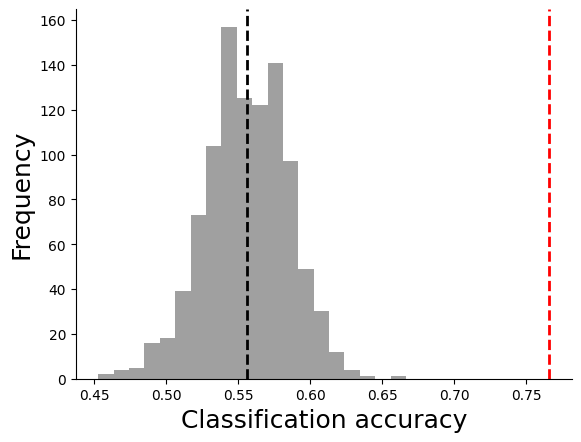

In [11]:

df_expanded = df.copy()

def set_type(row):
    if row['pre_rate'] > 7:
        return 1
    elif row['pre_rate'] < 7:
        return 2
    else:
        return None  


        
df_expanded['type'] = df_expanded.apply(set_type, axis=1)
df_expanded = df_expanded.dropna(subset=['type'])

print(df_expanded.shape)

X = df_expanded.drop(columns=['subject', 'change_time', 'pre_rate', 'change','type'])  # 特征是pattern
y = df_expanded['type']  # 目标是type


cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
svm_model = SVC(class_weight='balanced')

from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
score, permutation_scores, pvalue = permutation_test_score(
    svm_model, X, y, cv=cv, n_permutations=1000, n_jobs=-1, scoring="accuracy", random_state=42)

print(f"置换检验得分: {score:.2f}")
print(f"置换检验的p值: {pvalue:.4f}")
y_pred = cross_val_predict(svm_model, X, y, cv=loo)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y, y_pred)

# 输出混淆矩阵
print("混淆矩阵:")
print(conf_matrix)

# 输出详细的分类报告（精确率、召回率、F1-score）
print("分类报告:")
print(classification_report(y, y_pred))
accuracy = accuracy_score(y, y_pred)
print(f"loo 正确率: {accuracy:.2f}")


# 绘制直方图
plt.hist(permutation_scores, bins=20, alpha=0.75, color='grey', label='Permutation accuracy')

# 绘制实际准确率的红色虚线
plt.axvline(accuracy, color='red', linestyle='--', linewidth=2, label=f'Actual Accuracy ({score:.2f})')
# 绘制置换得分平均值的黑色虚线
plt.axvline(np.mean(permutation_scores), color='black', linestyle='--', linewidth=2, label=f'Mean Permutation Accuracy ({np.mean(permutation_scores):.2f})')

# 添加标签
plt.xlabel('Classification accuracy',fontsize=18)
plt.ylabel('Frequency',fontsize=18)

# 去除图表的边框
sns.despine()

# 显示图例
# plt.legend(loc='best')
# plt.xticks(fontsize=14)  # 调整 x 轴刻度字体大小
# plt.yticks(fontsize=14) 
# 显示图形
plt.show()
